In [2]:
import pandas as pd
import numpy as np

In [3]:
# get all of the relevant data frames
songDate = pd.read_csv('uniqueSongArtistDate.csv')
wordVecFeatures = pd.read_csv('wordVecFeatures.csv')
songMetaData= pd.read_csv('songMetadata.csv',encoding = "ISO-8859-1")
pca_dtm = pd.read_csv('pca_dtm.csv')
lda_top = pd.read_csv('ldaTop.csv')

In [510]:
songMetaData

,Unnamed: 0,Track Name,Artist,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,...,is_key_2,is_key_3,is_key_4,is_key_5,is_key_6,is_key_7,is_key_8,is_key_9,is_key_10,is_key_11
0,0,Bad and Boujee (feat. Lil Uzi Vert),Migos,0.061000,0.927,343150,0.665,0.000000,0.1230,-5.313,...,0,0,0,0,0,0,0,0,0,1
1,1,Fake Love,Drake,0.108000,0.927,210937,0.488,0.000000,0.1960,-9.433,...,0,0,0,0,0,0,0,1,0,0
2,2,Starboy,The Weeknd,0.165000,0.681,230453,0.594,0.000003,0.1340,-7.028,...,0,0,0,0,0,1,0,0,0,0
3,3,Closer,The Chainsmokers,0.414000,0.748,244960,0.524,0.000000,0.1110,-5.599,...,0,0,0,0,0,0,1,0,0,0
4,4,Black Beatles,Rae Sremmurd,0.130000,0.794,291893,0.646,0.000000,0.1400,-6.235,...,0,0,0,0,0,0,0,0,0,0
5,5,Broccoli (feat. Lil Yachty),DRAM,0.236000,0.886,225205,0.525,0.000000,0.0570,-7.390,...,0,0,0,0,0,0,1,0,0,0
6,6,One Dance,Drake,0.007840,0.791,173987,0.619,0.004230,0.3510,-5.886,...,0,0,0,0,0,0,0,0,0,0
7,7,Caroline,AminÃ©,0.174000,0.952,209640,0.318,0.000000,0.2050,-10.357,...,0,0,0,0,0,0,0,0,1,0
8,8,Let Me Love You,DJ Snake,0.078400,0.476,205947,0.718,0.000010,0.1220,-5.309,...,0,0,0,0,0,0,1,0,0,0
9,9,Bounce Back,Big Sean,0.105000,0.770,222360,0.567,0.000000,0.1250,-5.698,...,1,0,0,0,0,0,0,0,0,0


In [4]:
songDate['Date'] = pd.to_datetime(songDate['Date'])
songDate = songDate.drop(['URL','Unnamed: 0'],1)

In [5]:
# join everything to Train DF and then cluster!!
fullFeatureIndSong = songDate.merge(wordVecFeatures,on=['Track Name','Artist'])

In [6]:
fullFeatureIndSong = fullFeatureIndSong.merge(songMetaData,on=['Track Name','Artist'])

In [7]:
fullFeatureIndSong = fullFeatureIndSong.merge(pca_dtm,on=['Track Name','Artist'])

In [8]:
fullFeatureIndSong = fullFeatureIndSong.merge(lda_top,on=['Track Name','Artist'])

In [9]:
for ind,c in fullFeatureIndSong.isnull().sum().iteritems():
    if c > 0:
        print(ind,c)

In [ ]:
fullFeatureIndSong.isnull().sum()

In [53]:
type(fullFeatureIndSong.isnull().sum())

pandas.core.series.Series

In [11]:
# split into training and testing
# params to split by time
trainBefore = '2017-10-01' # can change
trainDf = fullFeatureIndSong[fullFeatureIndSong['Date']<= trainBefore]
testDf = fullFeatureIndSong[fullFeatureIndSong['Date']> trainBefore]

In [12]:
trainDf

,Track Name,Artist,Position,Streams,Date,Region,Unnamed: 0_x,Unnamed: 0.1,art_feat_0,art_feat_1,...,pca_feat_298,pca_feat_299,Unnamed: 0_y,love,Uncertainty,Explictives,German,Swedish,Dutch,Spanish
0,Bad and Boujee (feat. Lil Uzi Vert),Migos,1,1371493,2017-01-01,us,0,0,-0.000710,-0.001311,...,1.096351,-1.163444,0,0,0,1,0,0,0,0
1,Fake Love,Drake,2,1180074,2017-01-01,us,1,1,0.001028,0.000467,...,1.227985,0.612555,1,0,1,0,0,0,0,0
2,Starboy,The Weeknd,3,1064351,2017-01-01,us,2,2,0.001684,0.001790,...,-0.175895,-0.263147,2,0,1,0,0,0,0,0
3,Closer,The Chainsmokers,4,1010492,2017-01-01,us,3,3,0.000964,0.002493,...,-0.174602,0.570201,3,0,1,0,0,0,0,0
4,Black Beatles,Rae Sremmurd,5,874289,2017-01-01,us,4,4,0.001830,-0.000981,...,-0.527415,-0.680256,4,0,1,0,0,0,0,0
5,Broccoli (feat. Lil Yachty),DRAM,6,763259,2017-01-01,us,5,5,-0.000777,0.000777,...,-0.736414,0.941844,5,0,1,0,0,0,0,0
6,One Dance,Drake,7,753150,2017-01-01,us,6,6,0.001028,0.000467,...,0.109089,-0.183574,6,0,1,0,0,0,0,0
7,Let Me Love You,DJ Snake,9,690483,2017-01-01,us,8,8,0.001192,-0.000554,...,0.123938,-0.577541,8,1,0,0,0,0,0,0
8,Bounce Back,Big Sean,10,682688,2017-01-01,us,9,9,-0.001939,-0.001753,...,-0.119975,0.213018,9,0,1,0,0,0,0,0
9,I Feel It Coming,The Weeknd,11,651807,2017-01-01,us,10,10,0.001684,0.001790,...,-0.349509,0.386367,10,1,0,0,0,0,0,0


In [67]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [14]:
train_mat = trainDf[trainDf.columns[8:]].values
test_mat = testDf[trainDf.columns[8:]].values

In [15]:
mms = StandardScaler()

In [29]:
train_mat_norm = mms.fit_transform(train_mat)
test_mat_norm = mms.transform(test_mat)

In [ ]:
train_mat_norm

In [30]:
from sklearn.decomposition import PCA
comp = 50
pca_model = PCA(n_components = comp)

In [31]:
pca_fitmod = pca_model.fit(train_mat_norm)

In [32]:
variance = pca_fitmod.explained_variance_ratio_ #calculate variance ratios                                        
cv=np.cumsum(np.round(pca_model.explained_variance_ratio_,decimals=3)*100)

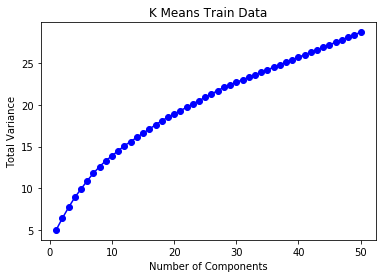

In [33]:
plt.plot(range(1,comp+1),cv, c='blue', marker='o')
plt.title('K Means Train Data')
plt.ylabel('Total Variance')
plt.xlabel('Number of Components')
#plt.show()
plt.savefig('VarianceDTM.png')

In [34]:
pca_model = PCA(n_components = 25)
pca_fitmod = pca_model.fit(train_mat)
pca_train = pca_fitmod.fit_transform(train_mat)
pca_test = pca_model.transform(test_mat)

## KMEANS With PCA Data

In [22]:
from sklearn.cluster import KMeans

In [23]:
# X can still be used
def KMeansTest(data):
    res = []
    for i in range(1,11):
        km = KMeans(i,'random', max_iter=300, random_state=0, n_init=30)
        km_fit = km.fit(data)
        res.append(km_fit.inertia_)
    return res

In [24]:
distortion = KMeansTest(pca_train)

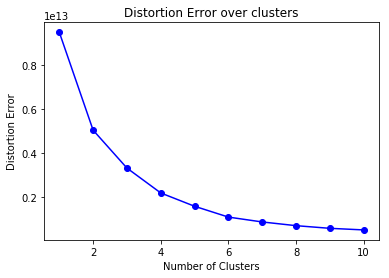

In [25]:
plt.plot(range(1,11),distortion, c='blue', marker='o')
plt.title('Distortion Error over clusters')
plt.ylabel('Distortion Error')
plt.xlabel('Number of Clusters')
plt.savefig('DistortionErr.png')

In [35]:
#2 is the magic number
km = KMeans(2,'random', max_iter=300, random_state=0, n_init=30)
km_fit = km.fit(pca_train)
train_pred_label = km_fit.labels_

In [36]:
test_pred_label = km_fit.predict(pca_test)

In [180]:
##update train and test 
train_mat_norm_class = np.append(train_mat_norm,np.transpose(np.matrix(train_pred_label)),1)
test_mat_norm_class = np.append(test_mat_norm,np.transpose(np.matrix(test_pred_label)),1)

In [194]:
def getClassCol(mat,cl):
    return np.squeeze(np.asarray(mat[:,-1] == cl))
    

In [204]:
## Time to split these up into groups and online learn
#train_c0 = train_mat_norm_class[getClassCol(train_mat_norm_class,0),:-1]
# test_c0 = test_mat_norm_class[getClassCol(test_mat_norm_class,0),:-1]

In [ ]:
trainDf['Clabel'] = train_pred_label
testDf['Clabel'] = test_pred_label

In [47]:
trainPCADf = pd.concat([trainDf[['Artist','Track Name']].reset_index(drop=True),pd.DataFrame(pca_train)],1)
trainPCADf['Clabel'] = train_pred_label
testPCADf = pd.concat([testDf[['Artist','Track Name']].reset_index(drop=True),pd.DataFrame(pca_test)],1)
testPCADf['Clabel'] = test_pred_label

In [48]:
trainPCADf.to_csv('trainTPCA.csv')
testPCADf.to_csv('testTPCA.csv')

## Data Preparation

In [379]:
dateStream = pd.read_csv('songRegionStreams.csv')
dateStream = dateStream.drop(['Unnamed: 0'],1)

In [380]:
dateStream.dtypes

Track Name    object
Artist        object
Position       int64
Streams        int64
Date          object
Region        object
dtype: object

In [381]:
dateStream = pd.concat([dateStream,pd.get_dummies(dateStream.Region)],1)
dateStream['Date'] = pd.to_datetime(dateStream.Date)
dateStream['Month'] = [x.month for x in dateStream.Date]
dateStream['Day'] = [x.day for x in dateStream.Date]
#dateStream[dateStream.columns[6:]] = dateStream[dateStream.columns[6:]].astype(float)
#dateStream[dateStream.columns[2:4]] = dateStream[dateStream.columns[2:4]].astype(float)

In [382]:
trainStream = dateStream.merge(trainPCADf,on=['Track Name','Artist'])
testStream = dateStream.merge(testPCADf,on=['Track Name','Artist'])

In [ ]:
trainStream

In [384]:
# split into model type then split into X and Y
def splitModelXY(trainData,modelNumber):
    trainMod = trainData[trainData['Clabel'] == modelNumber]
    XtrainMod = trainMod.sort_values('Date').reset_index(drop=True)
    trainScale = StandardScaler()
    YtrainMod = np.asarray(np.log(XtrainMod.Streams))
    XtrainMod = np.asarray(XtrainMod[XtrainMod.columns[6:-1]].values)
    XtrainMod = trainScale.fit_transform(XtrainMod)
    return (XtrainMod,YtrainMod,trainScale)
    

In [385]:
trainX1,trainY1,train1Scale1 = splitModelXY(trainStream,1)
trainX0,trainY0,train1Scale0 = splitModelXY(trainStream,0)

In [508]:
print(trainX1.shape)
print(trainX0.shape)

(116067, 36)
(337476, 36)


In [412]:
## handling test data
def splitModelXYTest(trainData,modelNumber,scalObj):
    trainMod = trainData[trainData['Clabel'] == modelNumber]
    artistSong = trainMod.drop_duplicates(['Track Name','Artist'])
    songCollection = []
    for i,r in artistSong.iterrows():
        sModel = trainMod[(trainMod['Track Name'] == r['Track Name']) \
                          & (trainMod['Artist'] == r['Artist'])]
        
        sModel = sModel.sort_values('Date').reset_index(drop=True)
        syMod = np.asarray(np.log(sModel.Streams))
        sxMod = np.asarray(sModel[sModel.columns[6:-1]].values)
        sxMod = scalObj.transform(sxMod)
        songCollection.append((r['Artist'],r['Track Name'],sxMod,syMod,sModel.Region,sModel.Date))
    return songCollection

In [413]:
testSong1 = splitModelXYTest(testStream,1,train1Scale1)
testSong0 = splitModelXYTest(testStream,0,train1Scale0)

In [509]:
print(len(testSong1))
print(len(testSong0))

272
1020


## Online Learning

In [366]:
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

In [414]:
# try one model on one class
sgd1 = SGDRegressor(max_iter = 300)

In [415]:
sgd1 = sgd1.fit(trainX1,trainY1)

In [416]:
sgd0 = SGDRegressor(max_iter=300).fit(trainX0,trainY0)

In [499]:
## MLP Regressor
mlp1 = MLPRegressor(hidden_layer_sizes=100,max_iter=300,alpha=0.25).fit(trainX1,trainY1)
mlp0 = MLPRegressor(hidden_layer_sizes=100,max_iter=300,alpha=0.25).fit(trainX0,trainY0)

In [467]:
## Initial testing then we can cross validate 
def generatePredictions(testSongArr,trainedModel):
    
    testSongtotal = []
    for a,b,tx,ty,r,d in testSongArr:
        predictedValue = []
        for j in range(len(ty)):
            predictedValue.append(trainedModel.predict(tx[j,:].reshape(1, -1)))
            trainedModel.partial_fit(tx[j,:].reshape(1, -1),np.array([ty[j]]))
        testSongtotal.append((a,b,tx,ty,predictedValue,r,d))
    return testSongtotal
    

In [500]:
testSong1Full = generatePredictions(testSong1,mlp1)
testSong0Full = generatePredictions(testSong0,mlp0)

In [501]:
maxVal = ()
maxlen = 0
for a,b,c,d,e,f,g in testSong0Full:
    if len(d) > maxlen:
        maxlen = len(d)
        maxVal = (a,b,c,d,e,f,g)


In [ ]:
maxVal

In [502]:
charlie = pd.DataFrame({'Actual':maxVal[3],'Pred':[x[0] for x in maxVal[4]],'Region':maxVal[5],'Date':maxVal[6]})

In [503]:
charlie_us = charlie[charlie.Region=='us']

In [504]:
charlie_us.index = pd.to_datetime(charlie_us.Date)

In [ ]:
charlie_us

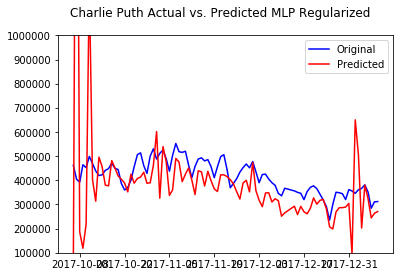

In [506]:
orig = plt.plot(np.exp(charlie_us.Actual),color='blue',label='Original')
mean = plt.plot(np.exp(charlie_us.Pred),color='red',label='Predicted')
#sd = plt.plot(rolsd,color='black',label='Sd')
plt.legend(loc='best')
plt.suptitle('Charlie Puth Actual vs. Predicted MLP Regularized')
axes = plt.gca()
axes.set_ylim([1e5,1e6])
plt.show(block=False)